# Liver Cirrhosis Stage Detection

Goal of this project is to create a model for Liver Cirrhosis stage detection. The data provided to us has sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.

Data contains 19 columns containing information about patients as follows:
1. N_Days: Number of days between registration and the earlier of death, transplantation,
or study analysis time in 1986
2. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
3. Drug: type of drug D-penicillamine or placebo
4. Age: age in days
5. Sex: M (male) or F (female)
6. Ascites: presence of ascites N (No) or Y (Yes)
7. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
8. Spiders: presence of spiders N (No) or Y (Yes)
9. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
10. Bilirubin: serum bilirubin in [mg/dl]
11. Cholesterol: serum cholesterol in [mg/dl]
12. Albumin: albumin in [gm/dl]
13. Copper: urine copper in [ug/day]
14. Alk_Phos: alkaline phosphatase in [U/liter]
15. SGOT: SGOT in [U/ml] (a liver enzyme)
16. Tryglicerides: triglicerides in [mg/dl]
17. Platelets: platelets per cubic [ml/1000]
18. Prothrombin: prothrombin time in seconds [s]
19. Stage: histologic stage of disease ( 1, 2, or 3 )

We will perform initial EDA and data cleaning, and then fit Random Forest, XGBoost, and DNN models for the dataset and compare the results in conclusion section.

## EDA and Data Preparation

In this part we will perform a basic EDA and prepare our data for model training.

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [306]:
#loading the dataset
df = pd.read_csv('liver_cirrhosis.csv')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [6]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,1887.117040,18495.877080,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,1091.690918,3737.596616,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,1080.000000,15694.000000,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,1680.000000,18499.000000,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,2576.000000,20955.000000,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.00000


Age is in days and while we are not seeing extreme or hidden NA values as we will see later on this dataset is far from perfect.

In [307]:
#changing the age to years instead of days and using floor logic to round down
df['Age'] = np.floor(df['Age']/365)
df.groupby('Stage').agg({'N_Days':'mean', 'Cholesterol':'mean', 'Age': 'median'})

,N_Days,Cholesterol,Age
Stage,,,
1,2284.828554,350.900239,48.0
2,1922.650634,402.436138,49.0
3,1454.632747,363.049538,53.0


In [14]:
df.groupby('Stage').agg({'Albumin':'mean', 'Platelets':'mean', 'Prothrombin': 'mean'})

,Albumin,Platelets,Prothrombin
Stage,,,
1,3.554295,285.558976,10.535287
2,3.566402,257.613371,10.496682
3,3.337860,224.924527,11.175197


On the basis of above preliminary analysis we can observe that all three stages have different values in main categories, implying that they are unique and distinct. One particular observation will be that Platelets and Albumin is generally lower for Stage 3 with a higher prothrombin, and this stage also less N_days or the days under study signifying either death or liver transplant or leaving the study altogether.

In [15]:
df.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

There are no specific na values in this dataset.

In [308]:
df.loc[df.duplicated(),:]

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
51,2224,C,Placebo,48.0,F,N,Y,N,N,0.9,346.000000,3.37,81.000000,1098.000000,122.450000,90.000000,298.0,10.0,1
69,2224,C,Placebo,48.0,F,N,Y,N,N,0.9,346.000000,3.37,81.000000,1098.000000,122.450000,90.000000,298.0,10.0,1
107,681,D,Placebo,31.0,F,N,N,N,N,1.2,369.510563,2.96,97.648387,1982.655769,122.556346,124.702128,293.0,10.9,2
149,617,CL,Placebo,42.0,F,Y,N,Y,N,5.5,369.510563,2.31,97.648387,1982.655769,122.556346,124.702128,102.0,10.8,3
154,1170,C,Placebo,45.0,F,N,Y,Y,S,1.3,369.510563,3.41,97.648387,1982.655769,122.556346,124.702128,430.0,11.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,D,D-penicillamine,64.0,F,N,N,N,N,0.8,231.000000,3.87,173.000000,9009.800000,127.710000,96.000000,295.0,11.0,2
24996,3584,D,D-penicillamine,64.0,F,N,N,N,N,0.8,231.000000,3.87,173.000000,9009.800000,127.710000,96.000000,295.0,11.0,2
24997,971,D,D-penicillamine,45.0,F,N,Y,Y,Y,5.1,369.510563,3.23,18.000000,790.000000,179.800000,124.702128,104.0,13.0,3
24998,3707,C,D-penicillamine,46.0,F,N,Y,N,N,0.8,315.000000,4.24,13.000000,1637.000000,170.500000,70.000000,426.0,10.9,2


Out of 25,000 rows in our original dataset we have 15,444 duplicate rows, this will impact the overall project as our model generally lacks enough data for all three stages to identify hidden representations. 

In [309]:
df = df.drop_duplicates()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9556 entries, 0 to 24992
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         9556 non-null   int64  
 1   Status         9556 non-null   object 
 2   Drug           9556 non-null   object 
 3   Age            9556 non-null   float64
 4   Sex            9556 non-null   object 
 5   Ascites        9556 non-null   object 
 6   Hepatomegaly   9556 non-null   object 
 7   Spiders        9556 non-null   object 
 8   Edema          9556 non-null   object 
 9   Bilirubin      9556 non-null   float64
 10  Cholesterol    9556 non-null   float64
 11  Albumin        9556 non-null   float64
 12  Copper         9556 non-null   float64
 13  Alk_Phos       9556 non-null   float64
 14  SGOT           9556 non-null   float64
 15  Tryglicerides  9556 non-null   float64
 16  Platelets      9556 non-null   float64
 17  Prothrombin    9556 non-null   float64
 18  Stage       

In [274]:
df.groupby('Stage').count()['Age']

Stage
0    3025
1    3308
2    3306
Name: Age, dtype: int64

After removing duplicateed we only have approximately 3000 samples for each stage.

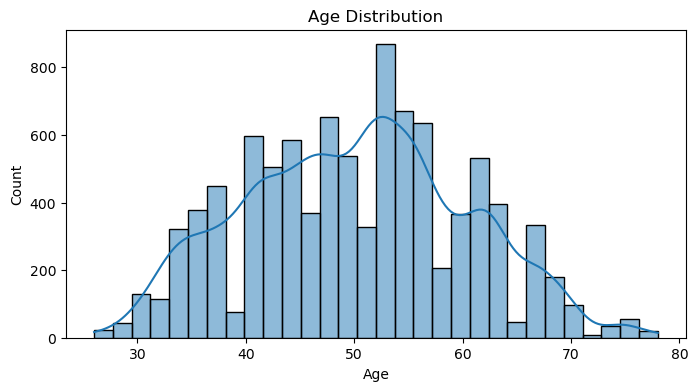

In [284]:
#age distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.show()

In [362]:
df['Age'].max()

78.0

Age is normally distributed with mean around 52.

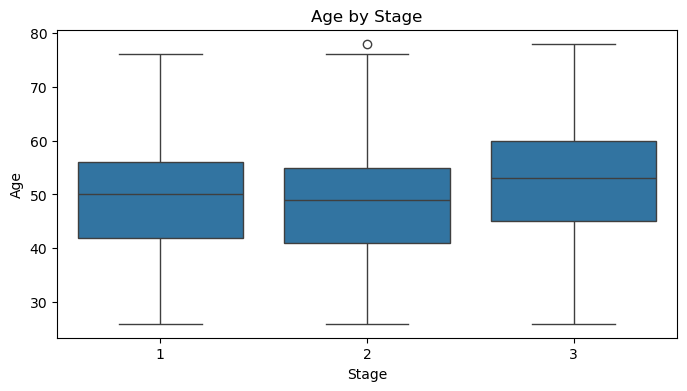

In [286]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Stage', y='Age', data=df)
plt.title('Age by Stage')
plt.show()

And as observed via tabular analysis, age for Stage 3 has different distribution than other stages.

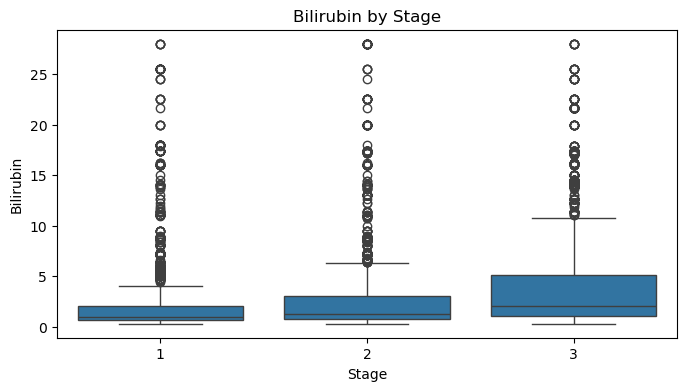

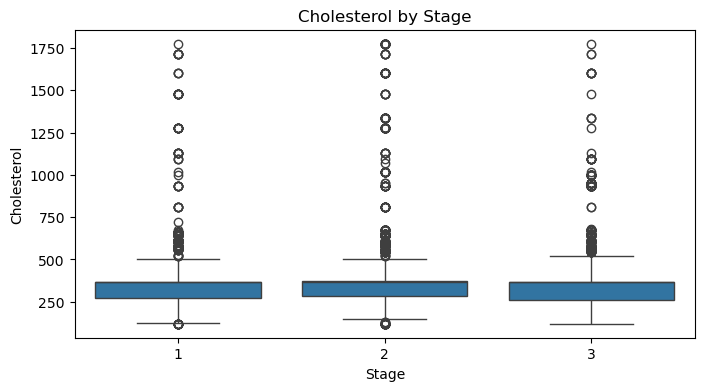

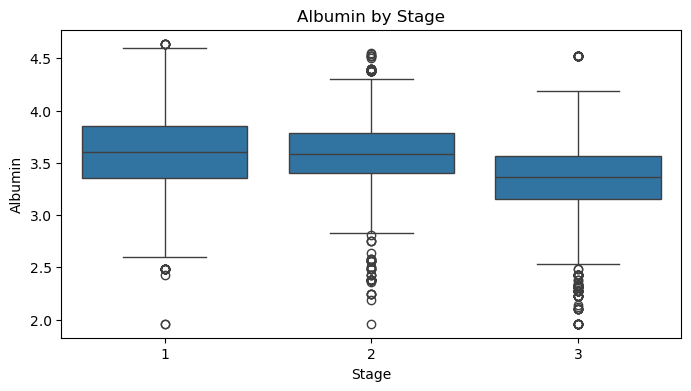

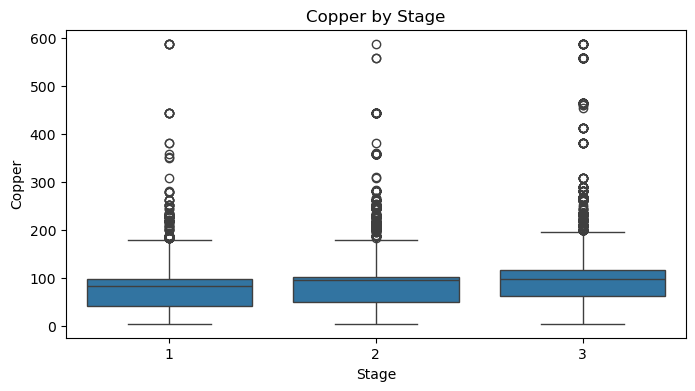

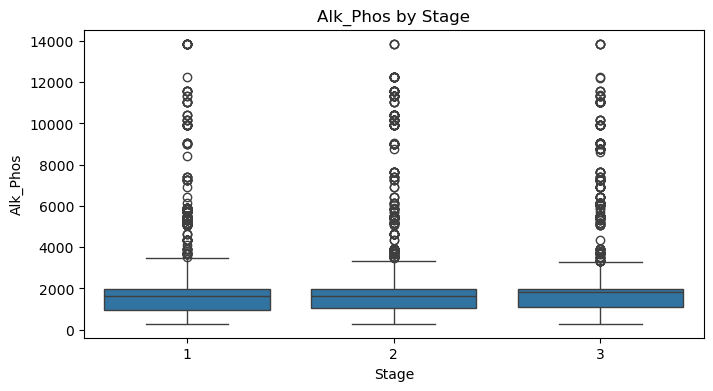

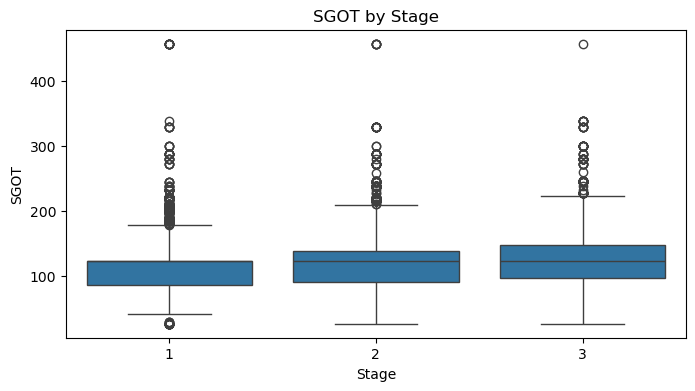

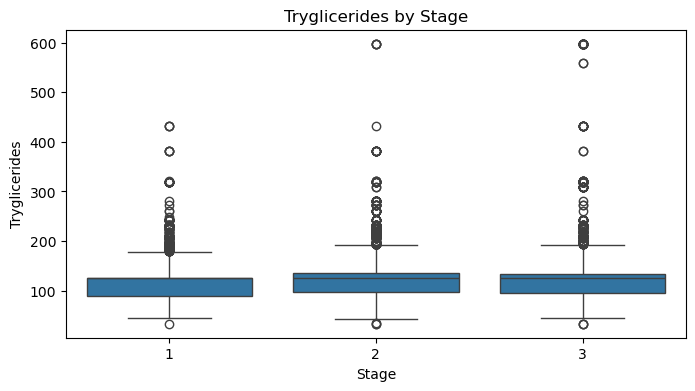

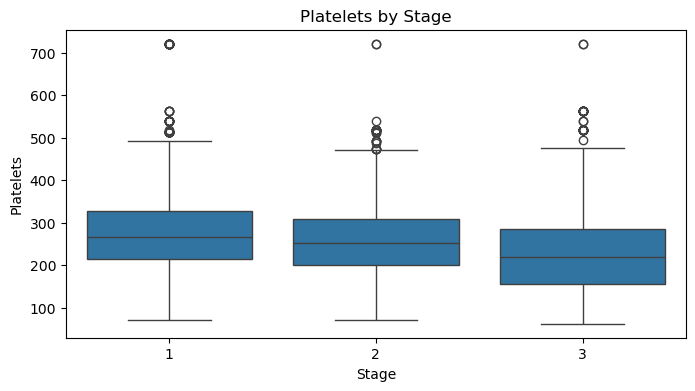

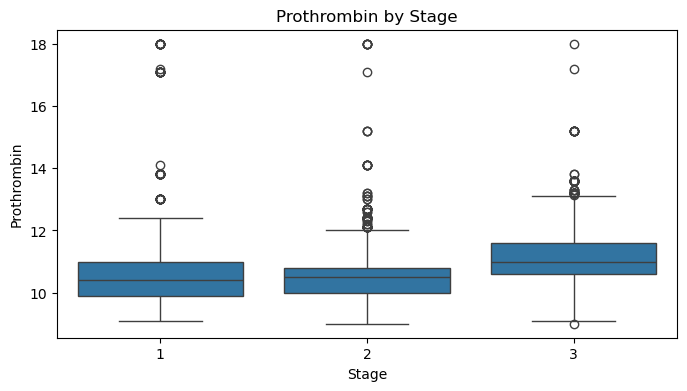

In [285]:
#boxplots for different liver tests
liver_tests = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
for col in liver_tests:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Stage', y=col, data=df)
    plt.title(f'{col} by Stage')
    plt.show()

For different liver tests, stage 3 generally has different distributions than other stages marking that while some tests are able to differentiate between Stage 1 and Stage 2, their test results are quite similarly distributed with Stage 3 having different distributions than them altogether.

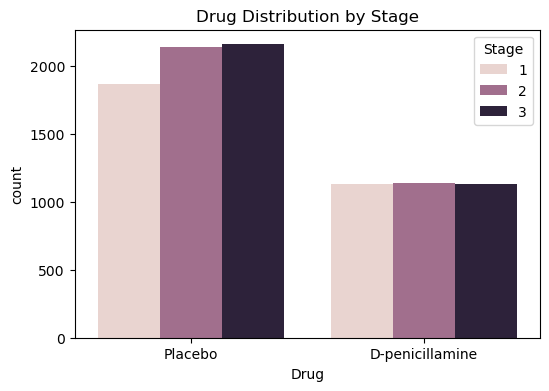

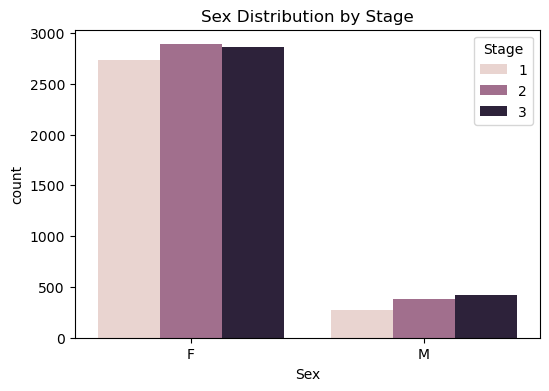

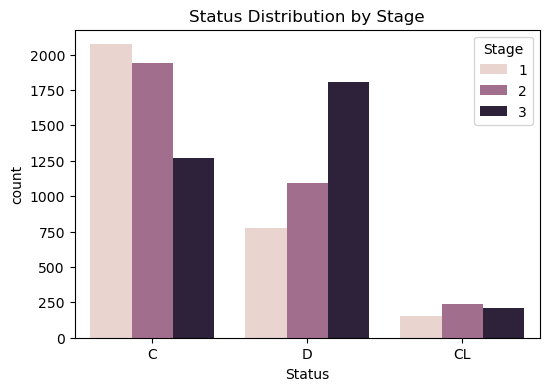

In [287]:
#bar plots for categorical variables based on stages

plt.figure(figsize=(6,4))
sns.countplot(x='Drug', hue='Stage', data=df)
plt.title('Drug Distribution by Stage')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Sex', hue='Stage', data=df)
plt.title('Sex Distribution by Stage')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Status', hue='Stage', data=df)
plt.title('Status Distribution by Stage')
plt.show()

In [294]:
df.groupby('Sex')['N_Days'].count()

Sex
F    8482
M    1074
Name: N_Days, dtype: int64

While the drug was used uniformally across the different stage patients, this study is heavily biased for women overall. This will impact the effect of model in real world use as its biased towards women and may not be able to predict properly for men, we need more data to rectify this.

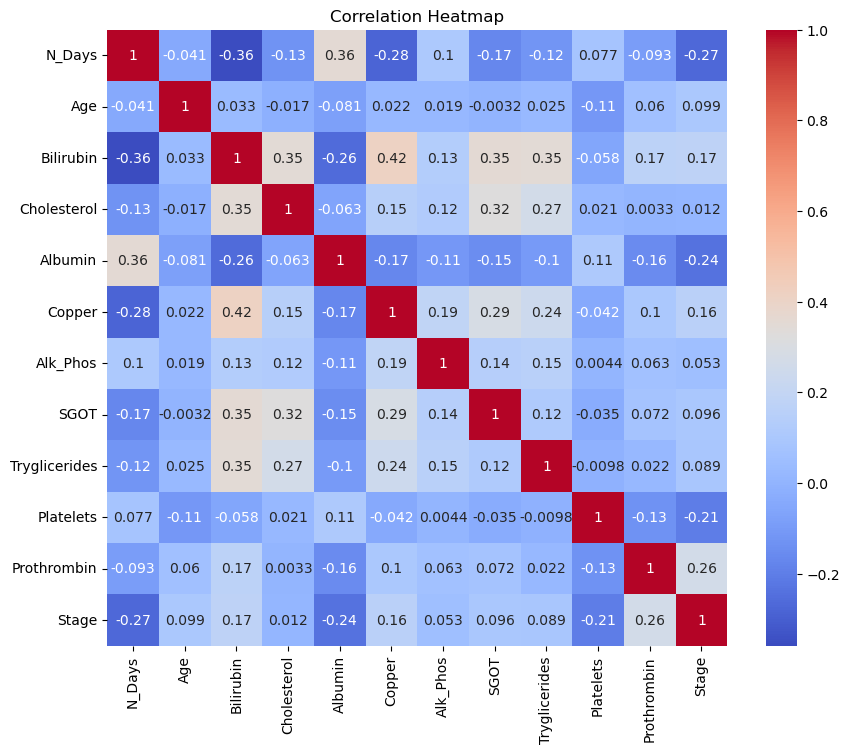

In [288]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

There are not specific high correlations overall, but some tests like Copper and Bilirubin has considerable correlation. And in regards to stage we can see that generally N_Days are inversely correlated with Stages, signifying that Stage 3 has low number of N_days as we observed before. Similarly Albumin and Platelets are less for Stage 3 or higher stages patiets and Prothrombin and Bilirubin are quite high for the higher stages patients.

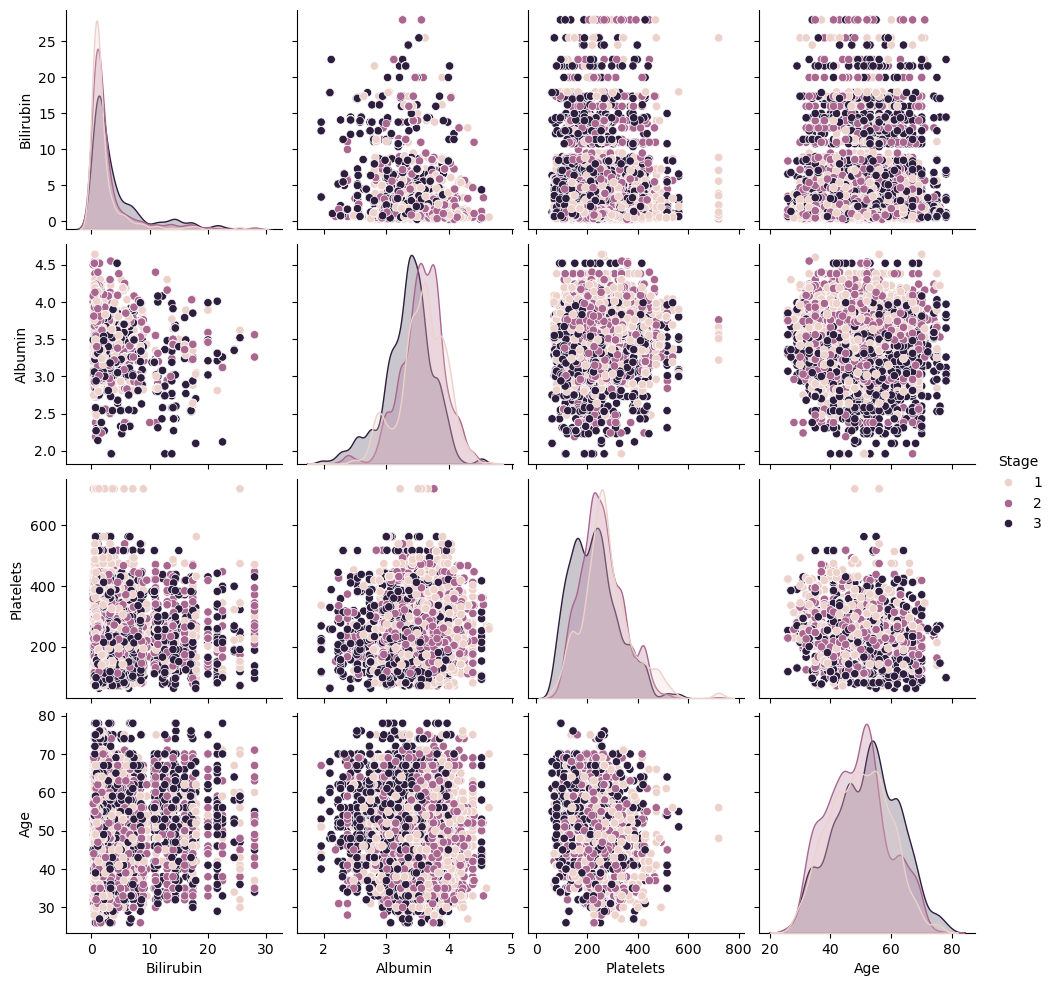

In [289]:
#pairplots for some tests
sns.pairplot(df, vars=['Bilirubin', 'Albumin', 'Platelets', 'Age'], hue='Stage')
plt.show()

In [310]:
df = pd.get_dummies(df) #one hot encoding for categorical data
le = LabelEncoder()
df['Stage'] = le.fit_transform(df['Stage']) #fixing the categories from [1,2,3] to [0,1,2]

In [280]:
df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,2221,18499,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,...,False,True,False,False,True,True,False,True,False,False
1,1230,19724,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,...,True,False,True,True,False,False,True,True,False,False
2,4184,11839,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,...,False,True,False,True,False,True,False,True,False,False
3,2090,16467,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,...,False,True,False,True,False,True,False,True,False,False
4,2105,21699,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,...,False,True,False,False,True,True,False,True,False,False


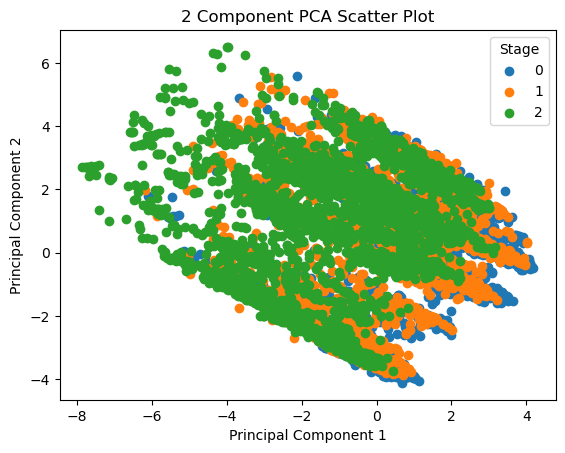

In [92]:
#PCA
pca_2 = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(df))

for stage in df['Stage'].unique():
    idx = df['Stage'] == stage
    plt.scatter(pca_2[idx, 0], pca_2[idx, 1], label=str(stage))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 Component PCA Scatter Plot')
plt.legend(title='Stage')
plt.show()

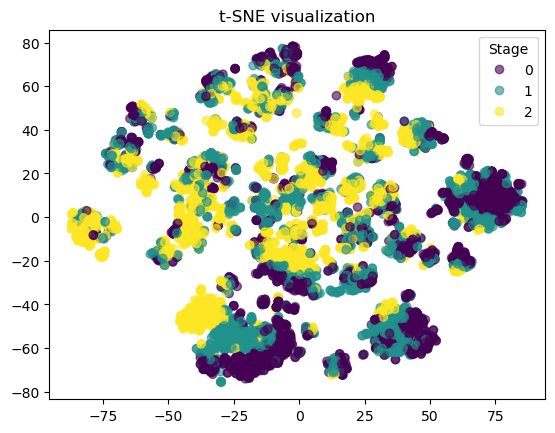

In [210]:
#T-SNE
tsne = TSNE(n_components = 2, perplexity = 50, learning_rate = 200, max_iter = 1000, random_state = 42)
X_embedded = tsne.fit_transform(StandardScaler().fit_transform(df))

scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df['Stage'], cmap='viridis', alpha=0.6)
plt.title("t-SNE visualization")

handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, ["0", "1", "2"], title="Stage")
plt.show()

On our default dataset without any further data augmentation we can see that while PCA was not able to differentiate the data points, t-SNE was able to differentiate quite well even if there are a lot of overlap remaining. This implies that there indeed exist valid difference across these stages of liver cirrhosis and with more data we could have had better result here and in modeling.

In [169]:
d_df = df.dtypes.reset_index()
flt_cols=  d_df.loc[d_df[0] == 'float64','index'].astype('str').values #identifying columns for expansion

In [201]:
#augmenting the dataset with polynomial features
pol_fts = PolynomialFeatures(degree = 2, include_bias = False).fit_transform(df[flt_cols])
df_aug = pd.concat([df.drop(columns = flt_cols).reset_index(drop = True), pd.DataFrame(pol_fts)], axis = 1)

In [202]:
df_aug.shape

(9639, 73)

In [205]:
df_aug.columns = df_aug.columns.astype('str')

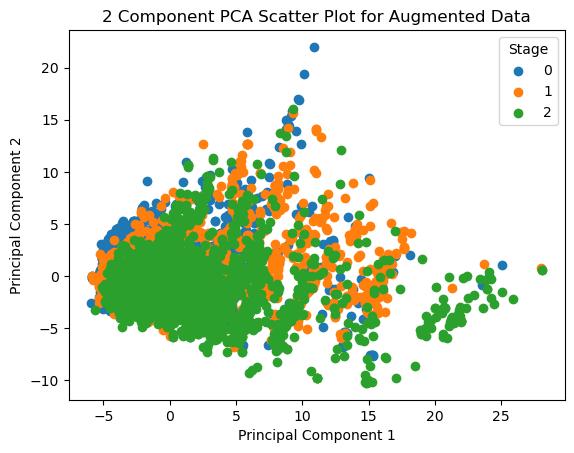

In [208]:
#PCA Augmented Data
pca_2 = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(df_aug))

for stage in df_aug['Stage'].unique():
    idx = df_aug['Stage'] == stage
    plt.scatter(pca_2[idx, 0], pca_2[idx, 1], label=str(stage))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 Component PCA Scatter Plot for Augmented Data')
plt.legend(title='Stage')
plt.show()

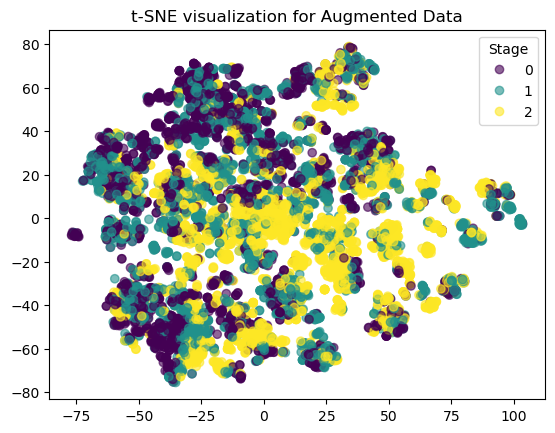

In [211]:
#t-SNE Augmented Data
tsne = TSNE(n_components = 2, perplexity = 50, learning_rate = 200, max_iter = 1000, random_state = 42)
X_embedded = tsne.fit_transform(StandardScaler().fit_transform(df_aug))

scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df['Stage'], cmap='viridis', alpha=0.6)
plt.title("t-SNE visualization for Augmented Data")

handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, ["0", "1", "2"], title="Stage")
plt.show()

PCA improved a lot as even with all the overlaps we can observe some blobs of data representing the different categories seperately. But for t-SNE plot while we can see better seperation for stage 3 or category 2 but we are also seeing more overlaps generally.

Our task for this project is to create models specifically, we can spend more time on EDA but we would spend more time on hyperparameter tuning and extracting as much information we can from this limited data.

In [164]:
d_df = df.dtypes.reset_index()
flt_cols=  d_df.loc[d_df[0] == 'float64','index'].astype('str').values

In [326]:
#preparing the dataset for model training
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 10)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state = 10)
X_train = df_train.drop(columns='Stage')
y_train = df_train['Stage']
X_val = df_val.drop(columns='Stage')
y_val = df_val['Stage']
X_test = df_test.drop(columns='Stage')
y_test = df_test['Stage'] 

In [327]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)

(7740, 27)
(956, 27)
(860, 27)
(7740,)


## Model Training

In this part we will fit XGBoost Model, Random Forest Model, and a DNN model. We will also perform hyperparameter tuning for the 

In [328]:
#fitting default XGBoost model

model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)
y_pred_xg = model_xg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("\n Classification_report: \n", classification_report(y_test, y_pred_xg))

Accuracy: 0.9027196652719666

 Classification_report: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       294
           1       0.88      0.90      0.89       338
           2       0.93      0.92      0.93       324

    accuracy                           0.90       956
   macro avg       0.90      0.90      0.90       956
weighted avg       0.90      0.90      0.90       956



In [329]:
#fitting default Random Forest Model

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n Classification_report: \n", classification_report(y_test, y_pred_rf))

Accuracy: 0.8598326359832636

 Classification_report: 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       294
           1       0.85      0.83      0.84       338
           2       0.88      0.93      0.90       324

    accuracy                           0.86       956
   macro avg       0.86      0.86      0.86       956
weighted avg       0.86      0.86      0.86       956



In [330]:
#bayesian optimization for XGBoost Model

search_space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'n_estimators': hp.choice('n_estimators', range(100, 500, 50)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_leaves': hp.choice('max_leaves', range(2, 10))
}

def objective(params):
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    score = accuracy_score(y_val, preds)
    return {'loss': -score, 'status': STATUS_OK}

trials_xg = Trials()
best_xg = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals = 50, trials=trials_xg)

100%|████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76trial/s, best loss: -0.8883720930232558]


In [344]:
#bayesian optimization for random forest

search_space_rf = {
    'max_depth': hp.choice('max_depth', range(5, 20)),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.001, 0.1),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 5)),
    'n_estimators': hp.choice('n_estimators', range(100, 400, 50)),
}

def objective_rf(params):
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    score = accuracy_score(y_val, preds)
    return {'loss': -score, 'status': STATUS_OK}

trials_rf = Trials()
best_rf = fmin(fn = objective_rf, space = search_space_rf, algo = tpe.suggest, max_evals = 50, trials = trials_rf)

100%|████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/trial, best loss: -0.7569767441860465]


In [331]:
best_xg

{'learning_rate': np.float64(0.21702731803109046),
 'max_depth': np.int64(2),
 'max_leaves': np.int64(7),
 'n_estimators': np.int64(6),
 'subsample': np.float64(0.9179803867158332)}

In [345]:
best_rf

{'ccp_alpha': np.float64(0.0013389786833798547),
 'max_depth': np.int64(13),
 'min_samples_leaf': np.int64(0),
 'min_samples_split': np.int64(1),
 'n_estimators': np.int64(1)}

In [349]:
#Tuned RF Model
model_rf_tuned = RandomForestClassifier(
    ccp_alpha = 0.00133,
    max_depth = 18,
    min_samples_leaf = 2,
    min_samples_split = 3,
    n_estimators = 150
)
model_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = model_rf_tuned.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("\n Classification_report: \n", classification_report(y_test, y_pred_rf_tuned))

Accuracy: 0.7615062761506276

 Classification_report: 
               precision    recall  f1-score   support

           0       0.75      0.76      0.76       294
           1       0.77      0.68      0.72       338
           2       0.76      0.85      0.80       324

    accuracy                           0.76       956
   macro avg       0.76      0.76      0.76       956
weighted avg       0.76      0.76      0.76       956



In [343]:
#Tuned XGBoost
model_xg_tuned = XGBClassifier(
    learning_rate = 0.217,
    max_depth = 5,
    max_leaves = 9,
    n_estimators = 400,
    subsample = 0.9179
)
model_xg_tuned.fit(X_train, y_train)
y_pred_xg_tuned = model_xg_tuned.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xg_tuned))
print("\n Classification_report: \n", classification_report(y_test, y_pred_xg_tuned))

Accuracy: 0.893305439330544

 Classification_report: 
               precision    recall  f1-score   support

           0       0.91      0.86      0.89       294
           1       0.86      0.89      0.88       338
           2       0.91      0.93      0.92       324

    accuracy                           0.89       956
   macro avg       0.89      0.89      0.89       956
weighted avg       0.89      0.89      0.89       956



In [350]:
#grid cv tuned randomforest, we performed grid search before bayesian optimization
model_rf_tuned = RandomForestClassifier(
    max_depth = 10,
    min_samples_split = 8,
    n_estimators = 350
)
model_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = model_rf_tuned.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("\n Classification_report: \n", classification_report(y_test, y_pred_rf_tuned))

Accuracy: 0.8294979079497908

 Classification_report: 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       294
           1       0.83      0.80      0.82       338
           2       0.82      0.89      0.85       324

    accuracy                           0.83       956
   macro avg       0.83      0.83      0.83       956
weighted avg       0.83      0.83      0.83       956



Still, even with grid search hyperparameter tuning we did not get better model performance compared to the default settings. For both of the Ensemble methods, we got best result with default model settings. We got 90% accuracy in XGBoost model and 86% accuracy in Random Forest.

One interesting thing to note, while hyper parameter tuning didn't work well in case of XGBoost we observed better recall for Stage 3 patients. With more data XGBoost and RF Model both can provide better results overeall.

In [351]:
#using augmented data for the tensorflow model as it improved test accuracy a bit

df_train, df_test = train_test_split(df_aug, test_size = 0.1, random_state = 10)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state = 10)
X_train = df_train.drop(columns='Stage')
y_train = df_train['Stage']
X_val = df_val.drop(columns='Stage')
y_val = df_val['Stage']
X_test = df_test.drop(columns='Stage')
y_test = df_test['Stage'] 

In [262]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [263]:
train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000)
val_df = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_df = tf.data.Dataset.from_tensor_slices(X_test).batch(32)

In [352]:
X_train.shape

(7807, 72)

In [265]:
input = tf.keras.Input(shape=(72,))

x = tf.keras.layers.Dense(128, activation='relu')(input)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

output = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs = input, outputs = output)

In [266]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,419 (95.39 KB)

 Trainable params: 24,419 (95.39 KB)

 Non-trainable params: 0 (0.00 B)

In [267]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [242]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [268]:
model_history = model.fit(
    train_df,
    validation_data = val_df,
    epochs = 200,
    callbacks = [es]
)

Epoch 1/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4972 - loss: 0.9818 - val_accuracy: 0.5945 - val_loss: 0.8551
Epoch 2/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6239 - loss: 0.8075 - val_accuracy: 0.6325 - val_loss: 0.8101
Epoch 3/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6625 - loss: 0.7448 - val_accuracy: 0.6555 - val_loss: 0.7780
Epoch 4/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7063 - loss: 0.6775 - val_accuracy: 0.6567 - val_loss: 0.7545
Epoch 5/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7169 - loss: 0.6574 - val_accuracy: 0.6717 - val_loss: 0.7399
Epoch 6/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7355 - loss: 0.6166 - val_accuracy: 0.6774 - val_loss: 0.7282
Epoch 7/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7553 - loss: 0.5855 - val_accuracy: 0.7051 - val_loss: 0.7177
Epoch 8/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7674 - loss: 0.5595 - val_acc

In [269]:
y_pred = np.argmax(model.predict(test_df), axis = 1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [270]:
#we got a bit better result with augmented data

print('Classification Report: \n')
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       273
           1       0.72      0.65      0.69       344
           2       0.78      0.81      0.80       347

    accuracy                           0.74       964
   macro avg       0.73      0.74      0.73       964
weighted avg       0.74      0.74      0.73       964



## Conclusion

We were provided dataset containing 25,000+ samples but most of them were repeated, leaving us only 9556 samples to work with, where more than 8000 samples were for Female sex. This dataset is not representative of population and could not be used for a population level predictor as its heavily biased in predicting liver damage stages for women mainly. We could have balanced it but we already had very limited data and balancing would either reduce the samples to 2000 or create duplicates for Men samples, both would not be ideal overall. Nevertheless, models we trained are using highly structured dataset manually procured by a popular research clinic so our models could be used in limited scenarios where proportion of women is quite high. 

Our best performing model is XGBoost Classifier with 90% accuracy, we also tried augmented data with polynomial features for many float based columns but it didn't perform better. Our Random Forest model achieved 86% accuracy and DNN Model only achieved 74% accuracy with very bad recall in Stage 2 liver cirrhosis stage.

We could get much better results overall if we have more data as XGBoost has scope of improvement alongwith other models.